In [11]:
# breast_cancer_classification.py
# 🧬 Breast Cancer Classification (UCI Wisconsin Diagnostic)
# Goal: Predict benign vs malignant from public UCI dataset.
# Falls back to sklearn's bundled dataset if the UCI URL isn't reachable.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

RANDOM_STATE = 100

In [12]:
def load_uci_or_fallback():
    """Load UCI breast cancer CSV; if not available, fall back to sklearn dataset."""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
    columns = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
    try:
        df = pd.read_csv(url, header=None, names=columns)
        df = df.drop(columns=["ID"])
        source = "UCI CSV"
    except Exception:
        from sklearn.datasets import load_breast_cancer
        data = load_breast_cancer(as_frame=True)
        df = data.frame.copy()
        # Align schema: use a "Diagnosis" column as M/B like UCI
        df = df.rename(columns={"target": "Diagnosis"})
        # sklearn: target 0=malignant, 1=benign
        df["Diagnosis"] = df["Diagnosis"].map({0: "M", 1: "B"})
        source = "sklearn fallback"
    return df, source

In [13]:
# 1) Load data
df, source = load_uci_or_fallback()
print("Data source:", source)
print(df.head())
print("\nDiagnosis counts:\n", df["Diagnosis"].value_counts())

Data source: UCI CSV
  Diagnosis  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0         M      17.99      10.38     122.80     1001.0    0.11840    0.27760   
1         M      20.57      17.77     132.90     1326.0    0.08474    0.07864   
2         M      19.69      21.25     130.00     1203.0    0.10960    0.15990   
3         M      11.42      20.38      77.58      386.1    0.14250    0.28390   
4         M      20.29      14.34     135.10     1297.0    0.10030    0.13280   

   feature_7  feature_8  feature_9  ...  feature_21  feature_22  feature_23  \
0     0.3001    0.14710     0.2419  ...       25.38       17.33      184.60   
1     0.0869    0.07017     0.1812  ...       24.99       23.41      158.80   
2     0.1974    0.12790     0.2069  ...       23.57       25.53      152.50   
3     0.2414    0.10520     0.2597  ...       14.91       26.50       98.87   
4     0.1980    0.10430     0.1809  ...       22.54       16.67      152.20   

   feature_24  fe

In [14]:
# 2) Preprocessing: encode target and scale features
y = (df["Diagnosis"] == "M").astype(int)   # M->1, B->0
X = df.drop(columns=["Diagnosis"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=RANDOM_STATE, test_size=0.2
)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)



=== Logistic Regression (No PCA) ===
Train accuracy: 0.9868131868131869
Test  accuracy: 0.9736842105263158

Classification report (no PCA):
                precision    recall  f1-score   support

   Benign (0)       0.99      0.97      0.98        72
Malignant (1)       0.95      0.98      0.96        42

     accuracy                           0.97       114
    macro avg       0.97      0.97      0.97       114
 weighted avg       0.97      0.97      0.97       114



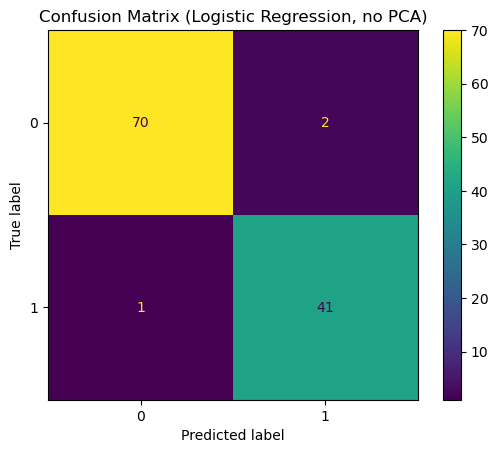

In [15]:
# 3) Logistic Regression (no PCA)
lr = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)
lr.fit(X_train_s, y_train)
print("\n=== Logistic Regression (No PCA) ===")
print("Train accuracy:", lr.score(X_train_s, y_train))
print("Test  accuracy:", lr.score(X_test_s, y_test))
print("\nClassification report (no PCA):\n",
      classification_report(y_test, lr.predict(X_test_s),
                            target_names=["Benign (0)","Malignant (1)"]))

ConfusionMatrixDisplay.from_estimator(lr, X_test_s, y_test)
plt.title("Confusion Matrix (Logistic Regression, no PCA)")
plt.show()


=== Logistic Regression (PCA = 2) ===
Train accuracy: 0.9604395604395605
Test  accuracy: 0.9473684210526315

Classification report (PCA=2):
                precision    recall  f1-score   support

   Benign (0)       0.96      0.96      0.96        72
Malignant (1)       0.93      0.93      0.93        42

     accuracy                           0.95       114
    macro avg       0.94      0.94      0.94       114
 weighted avg       0.95      0.95      0.95       114



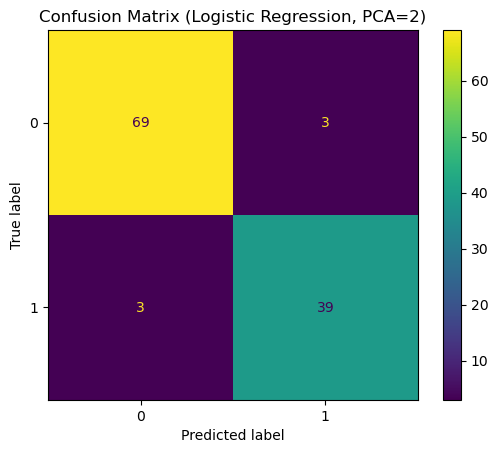

In [16]:
# 4) PCA to 2 components + Logistic Regression
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_p = pca.fit_transform(X_train_s)
X_test_p  = pca.transform(X_test_s)

lr_pca = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)
lr_pca.fit(X_train_p, y_train)
print("\n=== Logistic Regression (PCA = 2) ===")
print("Train accuracy:", lr_pca.score(X_train_p, y_train))
print("Test  accuracy:", lr_pca.score(X_test_p, y_test))
print("\nClassification report (PCA=2):\n",
      classification_report(y_test, lr_pca.predict(X_test_p),
                            target_names=["Benign (0)","Malignant (1)"]))

ConfusionMatrixDisplay.from_estimator(lr_pca, X_test_p, y_test)
plt.title("Confusion Matrix (Logistic Regression, PCA=2)")
plt.show()

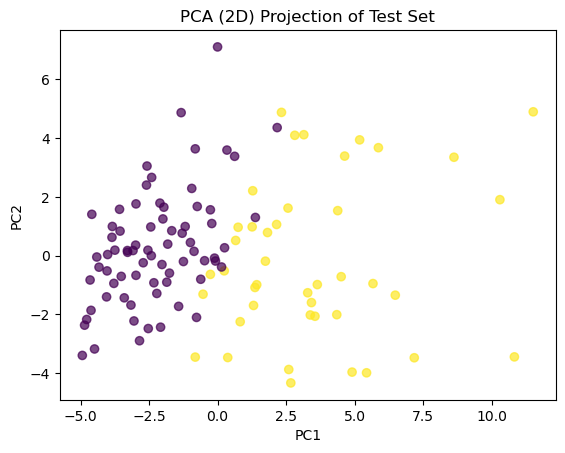

In [17]:
# 5) PCA scatter (visualization)
plt.figure()
plt.scatter(X_test_p[:, 0], X_test_p[:, 1], c=y_test, alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA (2D) Projection of Test Set")
plt.show()

# Notes / Next Steps:
# - Try L1/L2 regularization, C tuning, or tree-based models (RF/GBDT).
# - Add feature importance / SHAP to discuss interpretability.